In [1]:
import re
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from laserembeddings import Laser

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to /home/deck/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/deck/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/deck/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# read the Excel file into a pandas DataFrame
df = pd.read_excel('ips-t_stoermeldung.xlsx')

print(df.shape)

(4438, 1)


In [ ]:
sentences = df['FMT_TEXT']

print('\n'.join(sentences[:10]))

Maximum Error Message Length: 158


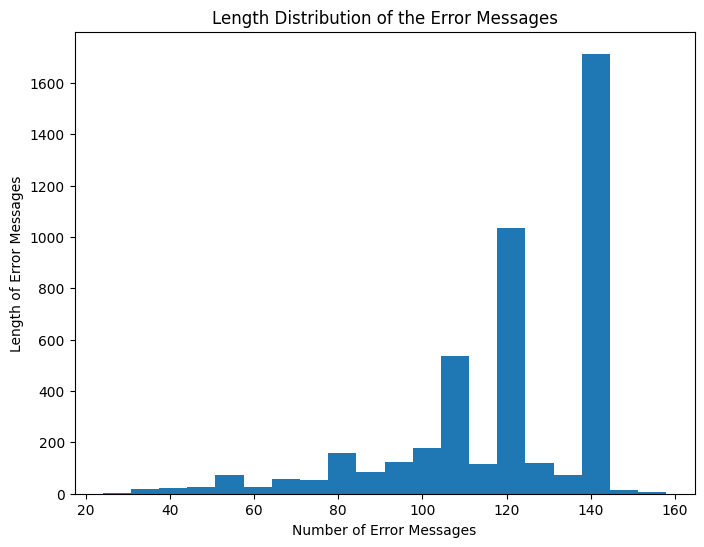

In [4]:
sentences_length = [len(sentence) for sentence in sentences]
print("Maximum Error Message Length:", max(sentences_length))

# Visualizing the length of the messages
plt.figure(figsize=(8, 6))
plt.hist(sentences_length, bins=20)
plt.xlabel('Number of Error Messages')
plt.ylabel('Length of Error Messages')
plt.title('Length Distribution of the Error Messages')
plt.savefig("Message Length.png")
plt.show()

## 1. Pre-Processing

#### 1.1. Lower Case

In [ ]:
# Convert all sentences to lowercase
cleaned_sentences = [sentence.lower() for sentence in sentences] # casefold() can be used to change 'ß' to 'ss'

print('\n'.join(cleaned_sentences[:10]))

#### 1.2. Stripping White Spaces

In [ ]:
# Prune white spaces
pattern = r"\s+"
cleaned_sentences = [re.sub(pattern, " ", sentence).strip() for sentence in cleaned_sentences]

print('\n'.join(cleaned_sentences[:10]))

#### 1.3. Text Cleaning

In [ ]:
# Pattern to match "FG" followed by any characters like "FG07ST006", "FG04ST008"
pattern = r"\b[f][g]\w*\b"
cleaned_sentences = [re.sub(pattern, "", sentence) for sentence in cleaned_sentences]

print('\n'.join(cleaned_sentences[:10]))

In [ ]:
# Pattern to match the band numbers (e.g., "Band 62", "Band55", "Band 51/2", "Band 62_2-63" and "Band 61-62_1")
pattern = r'band\s*\d+(?:[-_/]\d+)?'
cleaned_sentences = [re.sub(pattern, "", sentence) for sentence in cleaned_sentences]

print('\n'.join(cleaned_sentences[170:180]))

In [ ]:
# Pattern to match '0AB23369/G31 /EHB 126..', '0AB12600/G30 /EHB 13..', '0AB03496/G30 /EHB 16..', '0AB91697/G30 /EHB 22..', '0AB41642/G31 /EHB 23..'
pattern = r'0ab\d{5}/[a-z\d]{3}\s/ehb\s\d+\.\.'
cleaned_sentences = [re.sub(pattern, "", sentence) for sentence in cleaned_sentences]

print('\n'.join(cleaned_sentences[4000:4010]))

In [ ]:
# Pattern to remove vehicle ID numbers like "34/0AB20060/G82 /  2", "32/0AB24750/G31 /1392mm", "11/0AB36449/G30 /  0"
pattern = r"\d{2}/[a-z0-9]{8}/[a-z0-9]{3}\s*/\s*\w+\b"
cleaned_sentences = [re.sub(pattern, "", sentence) for sentence in cleaned_sentences]

print('\n'.join(cleaned_sentences[2000:2010]))

In [ ]:
# Pattern to remove patterns like "DB0177_0246_04", "DB0177_0270_04", ".DB0177_0080_03", "DB0021_0266_05"
pattern = r"\bdb\d{4}_\d{4}_\d{2}\b"
cleaned_sentences = [re.sub(pattern, "", sentence) for sentence in cleaned_sentences]

print('\n'.join(cleaned_sentences[170:180]))

In [ ]:
# Pattern to remove 'FC413-KK17', 'FC001-KK70', 'FC730-MA31', 'FC720'
pattern = r'fc\d{3}(?:-\w{2}\d{2})?'
cleaned_sentences = [re.sub(pattern, "", sentence) for sentence in cleaned_sentences]

print('\n'.join(cleaned_sentences[10:20]))

In [ ]:
# Pattern to remove '"++ft001+tl018"', '"++ft001+tl123"', '"++st003+ir001.sd001-kf70"'
pattern = r'"(?=\+).+?":'
cleaned_sentences = [re.sub(pattern, "", sentence) for sentence in cleaned_sentences]

print('\n'.join(cleaned_sentences[80:90]))

In [ ]:
# Pattern to remove 'EFZ21', 'EFZ01', 'EFZ23', 'EFZ64', 'EFZ70'
pattern = r'efz\d{2}'
cleaned_sentences = [re.sub(pattern, "", sentence) for sentence in cleaned_sentences]

print('\n'.join(cleaned_sentences[170:180]))

In [ ]:
# Pattern to remove 'FWK', 'FWK 1', 'FWK 12', 'FWK 116', 'FWK 34'
pattern = r'fwk(?: \d+)?'
cleaned_sentences = [re.sub(pattern, "", sentence) for sentence in cleaned_sentences]

print('\n'.join(cleaned_sentences[2420:2430]))

In [ ]:
# Pattern to remove 'VPR +425503', 'VPR +186000', 'VPR +163818', 'VPR +163820'
pattern = r'vpr \+\d+'
cleaned_sentences = [re.sub(pattern, "", sentence) for sentence in cleaned_sentences]

print('\n'.join(cleaned_sentences[2570:2580]))

In [ ]:
# Pattern to remove '123m', '45m'
pattern = r'\d+m{1,2}'
cleaned_sentences = [re.sub(pattern, "", sentence) for sentence in cleaned_sentences]

print('\n'.join(cleaned_sentences[320:330]))

In [ ]:
# Pattern to remove '32/0dxxleer/..../ 0', '12/0dxxleer/..../ 0', '37/0dxxleer/..../ 0', '27/0dxxleer/..../ 0'
pattern = r'\b\d{2}/0dxxleer/\.{3,}/\s0\b'
cleaned_sentences = [re.sub(pattern, "", sentence) for sentence in cleaned_sentences]

print('\n'.join(cleaned_sentences[500:510]))

In [ ]:
# Pattern to remove 'st001-002', 'st004', 'st006_v60', 'st904', 'st926', 'sg133', 'sg002', 'sg053', 'sg101', 'sg941', 'tl001'
pattern = r'[a-z]{2}\d{3}(?:-\d{3})?(?:_v\d+)?'
cleaned_sentences = [re.sub(pattern, "", sentence) for sentence in cleaned_sentences]

print('\n'.join(cleaned_sentences[2260:2270]))

In [ ]:
# Pattern to remove 'b50049', 'b50et16', 'b50tt14', 'b51at003', 'ts602re', 'th131f02', 'b50et15'
pattern = r'[a-z]{1,2}\d{2}[a-z]{0,2}\d{0,2}'
cleaned_sentences = [re.sub(pattern, "", sentence) for sentence in cleaned_sentences]

print('\n'.join(cleaned_sentences[2500:2510]))

In [ ]:
# Pattern to remove 'PRG 97/03/005/22', 'PRG 01/03/045/12', 'PRG 97/11/073/31', 'PRG 97/03/005/22', 'PRG 40/13/011/02'
pattern = r'prg \d{2}/\d{2}/\d{3}/\d{2}'
cleaned_sentences = [re.sub(pattern, "", sentence) for sentence in cleaned_sentences]

print('\n'.join(cleaned_sentences[4260:4270]))

In [ ]:
# Pattern to remove everything following '@'
pattern = r'@.*'
cleaned_sentences = [re.sub(pattern, "", sentence) for sentence in cleaned_sentences]

print('\n'.join(cleaned_sentences[100:110]))

In [ ]:
# Pattern to remove '....'
pattern = r'\.{4,}'
cleaned_sentences = [re.sub(pattern, "", sentence) for sentence in cleaned_sentences]

print('\n'.join(cleaned_sentences[380:390]))

#### 1.4. Stop Words Removal

In [ ]:
# Create a stop word object
stop_words = set(stopwords.words('german'))
filtered_sentences = []

for sentence in cleaned_sentences:
    tokens = word_tokenize(sentence)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    filtered_sentence = ' '.join(filtered_tokens)
    filtered_sentences.append(filtered_sentence)

print('\n'.join(filtered_sentences[:10]))

#### 1.5. Stemming

In [ ]:
# Create a stemmer object
stemmer = SnowballStemmer("german")
stemmed_sentences = []

# Perform stemming each sentence
for sentence in filtered_sentences:
    stemmed_words = [stemmer.stem(word) for word in sentence.split()]
    stemmed_sentence = " ".join(stemmed_words)
    stemmed_sentences.append(stemmed_sentence)

print('\n'.join(stemmed_sentences[:10]))

#### 1.6. Lemmatization

In [ ]:
# Create a lemmatizer object
lemmatizer = WordNetLemmatizer()
lemmatized_sentences = []

# Lemmatize each sentence
for sentence in stemmed_sentences:
    # Tokenize the sentence into words
    words = nltk.word_tokenize(sentence, language='german')
    
    # Lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join the lemmatized words back into a sentence
    lemmatized_sentence = ' '.join(lemmatized_words)
    
    # Add the lemmatized sentence to the list
    lemmatized_sentences.append(lemmatized_sentence)

# Print the lemmatized sentences
print('\n'.join(lemmatized_sentences[:10]))

In [27]:
# Creating a file to visualize the pre-processed messages
column1 = []
column2 = []
column3 = []

for sentence, clean, lemma in zip(sentences, cleaned_sentences, lemmatized_sentences):
    column1.append(sentence)
    column2.append(clean)
    column3.append(lemma)

# Create a dataframe from the lists
clean_df = pd.DataFrame({
    'Error Message': column1,
    'Cleaned': column2,
    'Lemmatized': column3,
})

clean_df.to_csv("Processed Messages.csv", index=False)
clean_df.to_excel("Processed Messages.xlsx", index=False)

#### 1.7. Feature Extraction

In [28]:
# Load LASER embeddings
laser = Laser()

# Get sentence embeddings using LASER for German language
embeddings = laser.embed_sentences(lemmatized_sentences, lang='de')

#### 1.8. Dimensionality Reduction

In [ ]:
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2)
reduced_embeddings = tsne.fit_transform(embeddings)

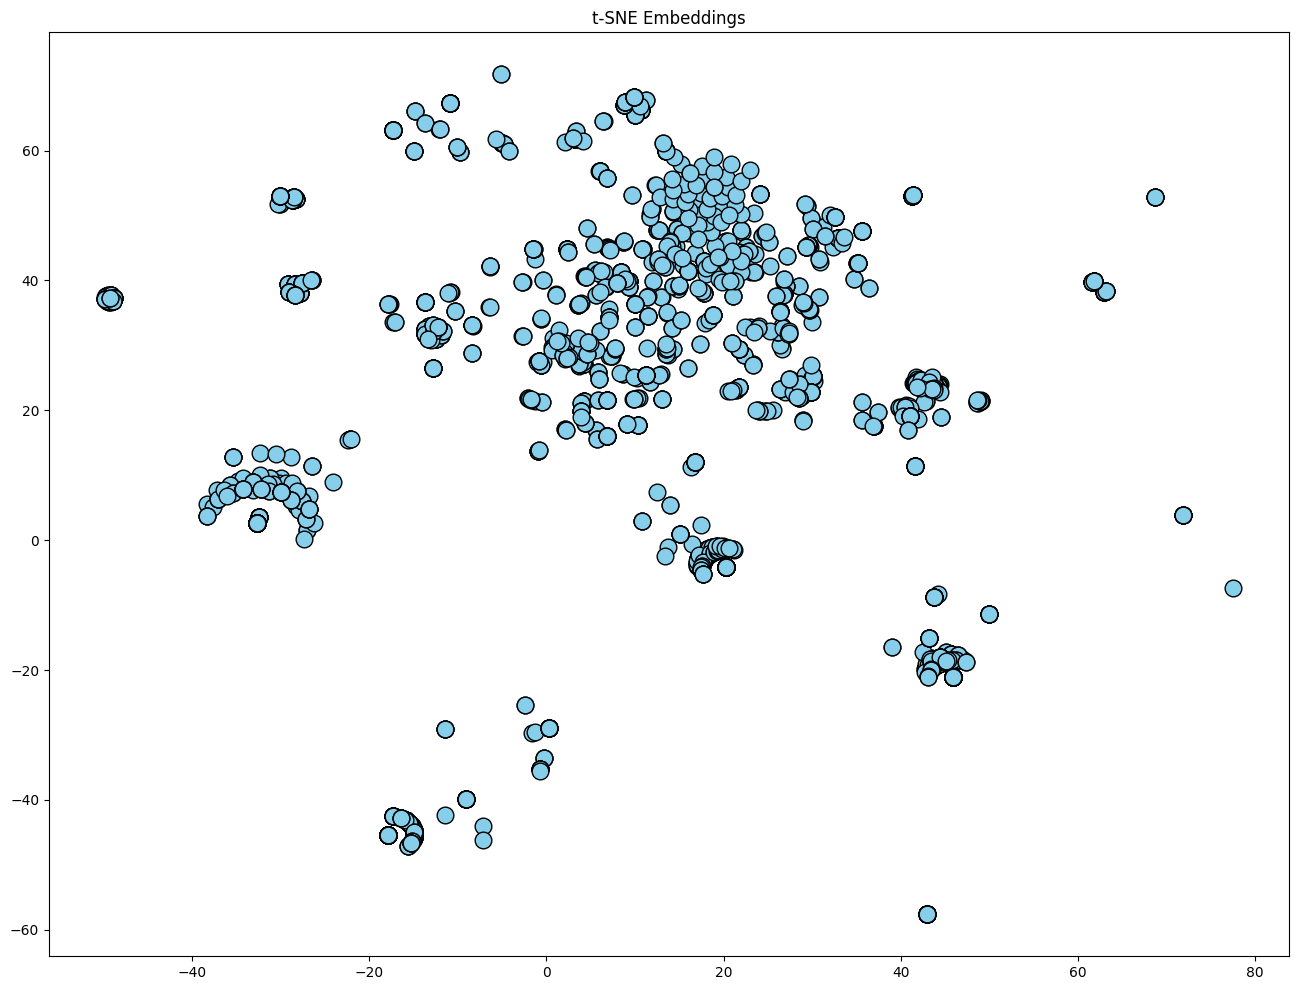

In [30]:
# Create a scatter plot of the t-SNE embeddings
plt.figure(figsize=(16, 12))
plt.plot(
reduced_embeddings[:, 0],
reduced_embeddings[:, 1],
'o',
markerfacecolor="skyblue",
markeredgecolor="k",
markersize=12,
)
plt.title("t-SNE Embeddings")
plt.savefig("t-SNE Embeddings.png")
plt.show()

## 2. Clustering

#### 2.1. K-MEANS

In [ ]:
# Performing K-Means for different values of K and performing the elbow method
wcss = []
k_values = range(1, 50)
for i in k_values:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init = 'auto')
    kmeans.fit(reduced_embeddings)
    wcss.append(kmeans.inertia_)

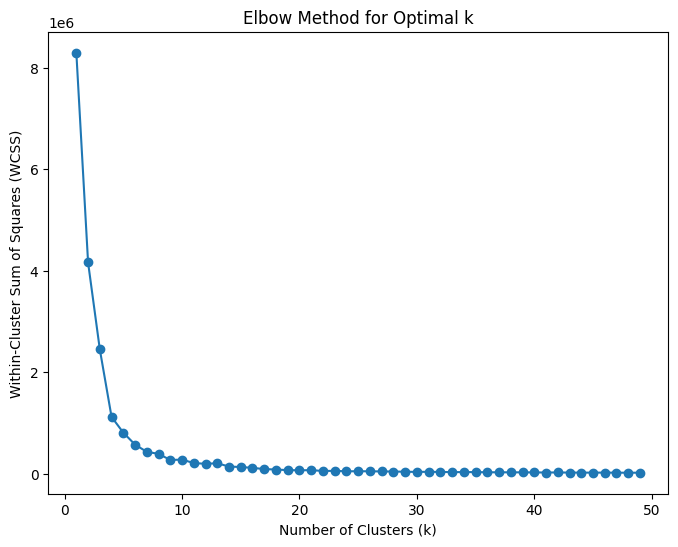

In [32]:
# Plot the WCSS values to find optimal K
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.savefig("KMeans/KMeans Elbow Method.png")
plt.show()

In [ ]:
# Number of clusters
k = 10

# Perform kmean clustering
kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 'auto')
kmeans_clusters = kmeans.fit_predict(reduced_embeddings)

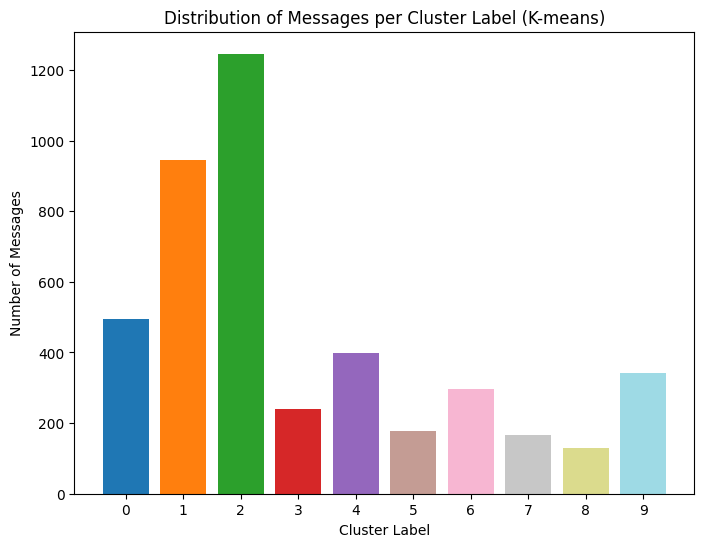

In [34]:
# Count the number of messages per cluster label
kmeans_label_counts = np.bincount(kmeans_clusters)

# Generate x-axis values (cluster labels)
labels = np.arange(len(kmeans_label_counts))
colors = [plt.cm.tab20(each) for each in np.linspace(0, 1, k)]

# Plot the bar graph
plt.figure(figsize=(8, 6))
plt.bar(labels, kmeans_label_counts, color=colors)

# Set x-axis ticks and labels
plt.xticks(labels)
plt.xlabel("Cluster Label")

# Set y-axis label
plt.ylabel("Number of Messages")

# Set title
plt.title("Distribution of Messages per Cluster Label (K-means)")
plt.savefig("KMeans/KMeans Error Message Distriution.png")

# Show the plot
plt.show()

In [35]:
# Calculate the silhouette score
silhouette_avg = silhouette_score(reduced_embeddings, kmeans_clusters)

print("The average silhouette score for K-Means is:", silhouette_avg)

The average silhouette score for K-Means is: 0.76430255


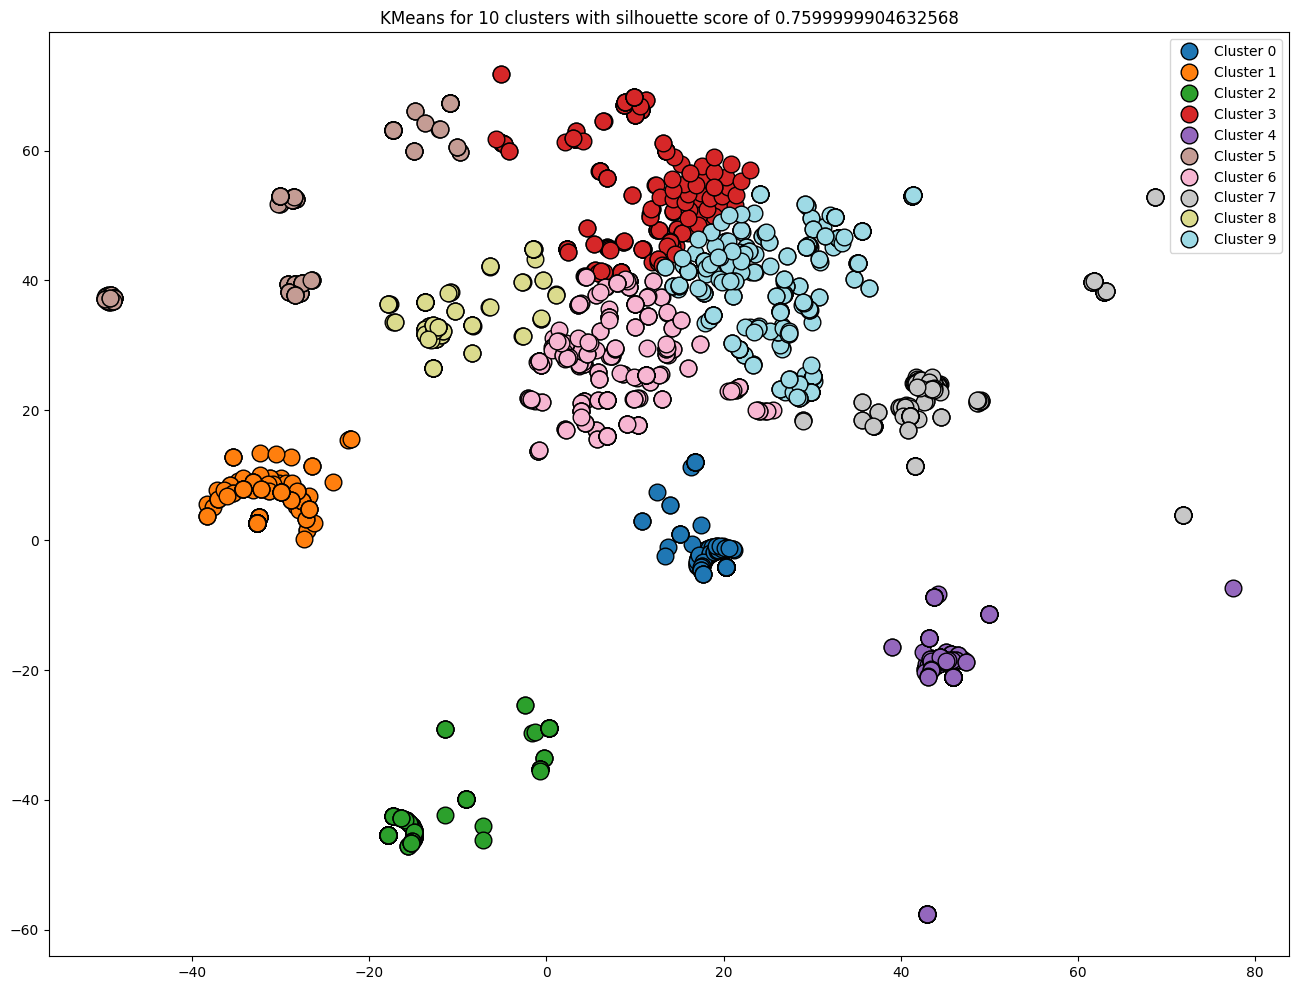

In [36]:
# Plot the scatter plot
plt.figure(figsize=(16, 12))

colors = [plt.cm.tab20(each) for each in np.linspace(0, 1, k)]
for i, color in zip(range(k), colors):

    cluster_points = reduced_embeddings[kmeans_clusters == i]

    plt.plot(
    cluster_points[:, 0],
    cluster_points[:, 1],
    'o',
    markerfacecolor=tuple(color),
    markeredgecolor="k",
    markersize=12,
    label=f"Cluster {i}",
    )

plt.title(f"KMeans for {k} clusters with silhouette score of {round(silhouette_avg, 2)}")
plt.legend()
plt.savefig("KMeans/KMeans Clusters.png")
plt.show()

In [ ]:
# Saving the cluster values with their respective error messages.
column1 = []
column2 = []

# Print the updated cluster assignments
for i, cluster_label in enumerate(kmeans_clusters):
  column1.append(sentences[i])
  column2.append(cluster_label)

# Create a dataframe from the lists
kmeans_df = pd.DataFrame({
    'Error Message': column1,
    'Cluster': column2
})

# Print the resulting dataframe
print(kmeans_df)

kmeans_df.to_csv("KMeans/KMeans Clusters.csv", index=False)
kmeans_df.to_excel("KMeans/KMeans Clusters.xlsx", index=False)

In [38]:
# Saving the K-Means model
with open('KMeans/KMeans Model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

#### 2.2. DBSCAN

In [39]:
db = DBSCAN(eps=4, min_samples=20)
db_clusters = db.fit_predict(reduced_embeddings)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_clusters)) - (1 if -1 in db_clusters else 0)
n_noise_ = list(db_clusters).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 17
Estimated number of noise points: 239


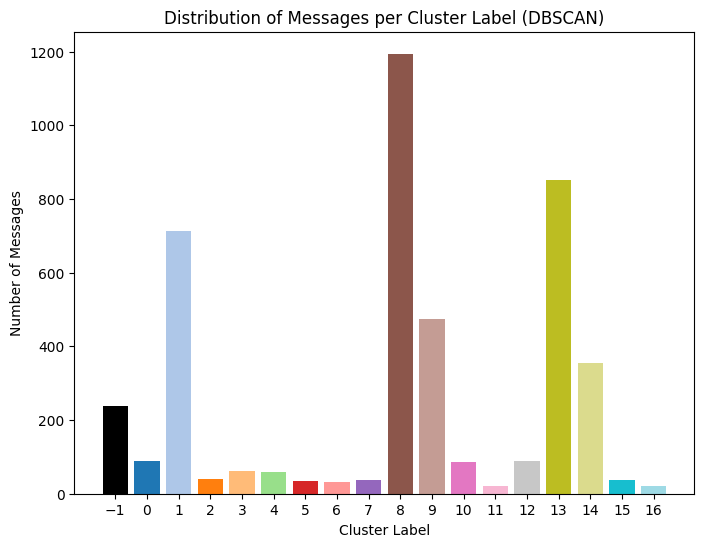

In [40]:
# Count the number of messages per cluster label
unique_labels, label_counts = np.unique(db_clusters, return_counts=True)
colors = [plt.cm.tab20(each) for each in np.linspace(0, 1, n_clusters_)]

if n_noise_ != 0:
    colors.insert(0,[0,0,0,1])

# Plot the bar graph
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, label_counts, color=colors)

# Set x-axis ticks and labels
plt.xticks(unique_labels)
plt.xlabel("Cluster Label")

# Set y-axis label
plt.ylabel("Number of Messages")

# Set title
plt.title("Distribution of Messages per Cluster Label (DBSCAN)")
plt.savefig("DBSCAN/DBSCAN Error Message Distriution.png")

# Show the plot
plt.show()

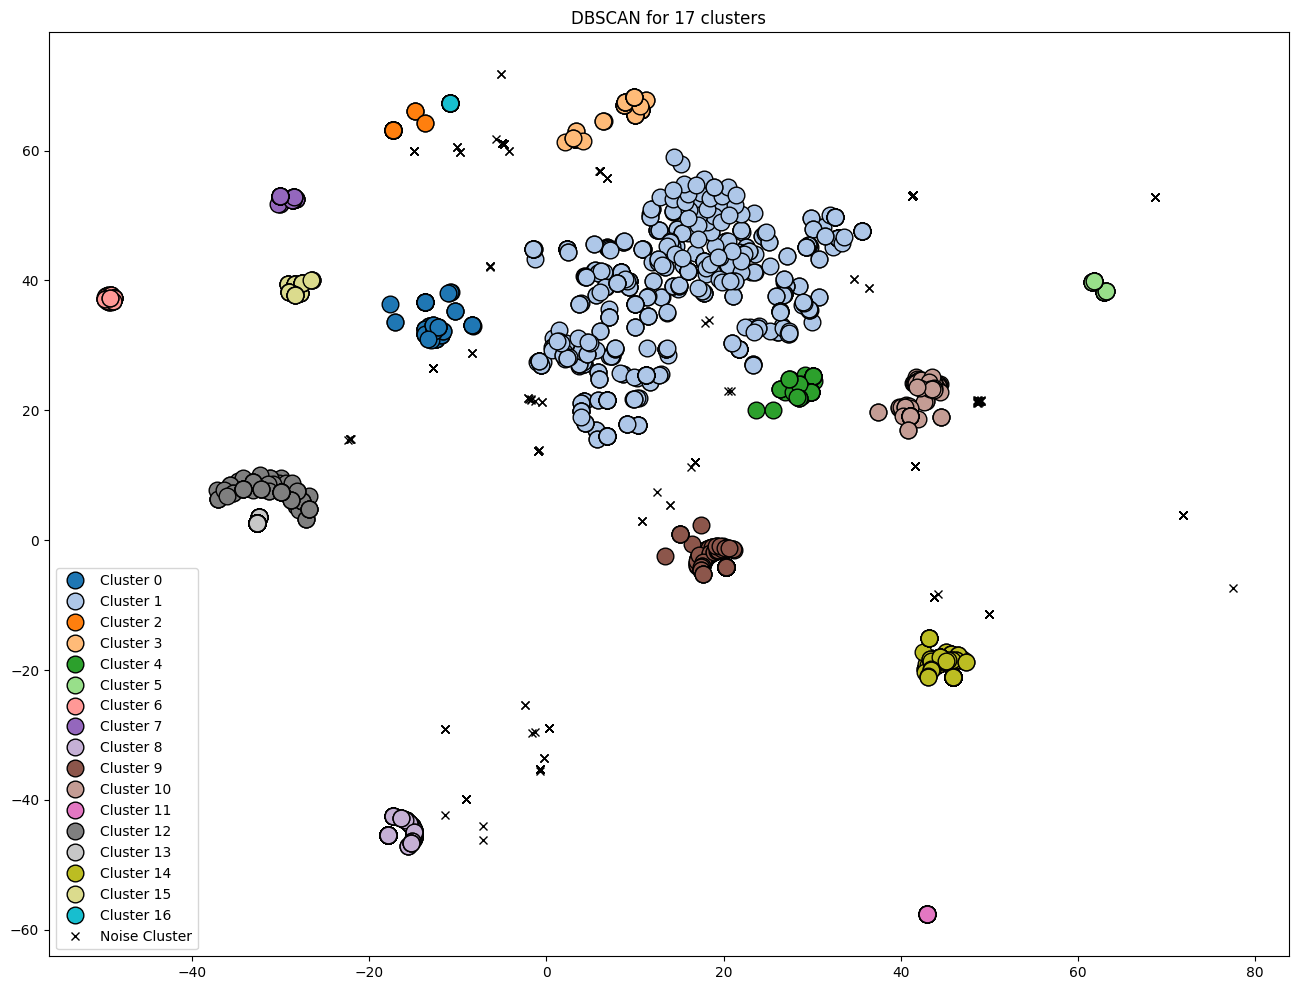

In [41]:
unique_clusters = set(db_clusters)
core_samples_mask = np.zeros_like(db_clusters, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

plt.figure(figsize=(16, 12))
colors = [plt.cm.tab20(each) for each in np.linspace(0, 1, len(unique_clusters))]

legend_labels = []

for k, col in zip(unique_clusters, colors):
    class_member_mask = db_clusters == k

    xy = reduced_embeddings[class_member_mask & ~core_samples_mask] if k == -1 else reduced_embeddings[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "x" if k == -1 else "o",
        markerfacecolor=tuple([0, 0, 0, 1] if k == -1 else col),
        markeredgecolor="k",
        markersize=6 if k == -1 else 12,
        label=f"Noise Cluster" if k == -1 else f"Cluster {k}"
    )

    legend_labels.append(f"Noise Cluster" if k == -1 else f"Cluster {k}")

plt.title(f"DBSCAN for {n_clusters_} clusters")

# Add legend for all clusters
plt.legend(legend_labels)
plt.savefig("DBSCAN/DBSCAN Clusters.png")
plt.show()

In [42]:
# Saving the cluster values with their respective error messages.
column1 = []
column2 = []

# Print the updated cluster assignments
for i, label in enumerate(db_clusters):
  column1.append(sentences[i])
  column2.append(label)

# Create a dataframe from the lists
dbscan_df = pd.DataFrame({
    'Error Message': column1,
    'Cluster': column2
})

dbscan_df.to_csv("DBSCAN/DBSCAN Clusters.csv", index=False)
dbscan_df.to_excel("DBSCAN/DBSCAN Clusters.xlsx", index=False)

In [43]:
# Saving the DBSCAN model
with open('DBSCAN/DBSCAN Model.pkl', 'wb') as f:
    pickle.dump(db, f)